In [1]:
import pandas as pd
import seaborn as sns

In [2]:
learning_curves = pd.read_csv('loss.csv', index_col=0, header=[0,1])
learning_curves

training              testing           validation          
           loss     auroc       loss     auroc       loss     auroc
0     67.505906  0.498252  59.517601  0.542089  63.406377  0.502090
1     16.157957  0.521712  19.869646  0.455768  19.592989  0.469030
2      2.190946  0.510273   2.189222  0.513407   2.196880  0.468402
3     57.436714  0.523639  57.481243  0.512857  61.340237  0.506379
4     83.880029  0.480692  82.455848  0.516699  86.807914  0.489051
...         ...       ...        ...       ...        ...       ...
9995  95.861828  0.496213  84.838108  0.529136  90.074387  0.465240
9996  69.155930  0.499110  67.052648  0.515594  67.190625  0.488840
9997  57.469839  0.497668  56.883740  0.489663  50.225777  0.524574
9998  53.235893  0.516007  50.274433  0.491881  48.688857  0.494079
9999  45.963830  0.502600  47.367215  0.513149  49.686498  0.520470

[10000 rows x 6 columns]

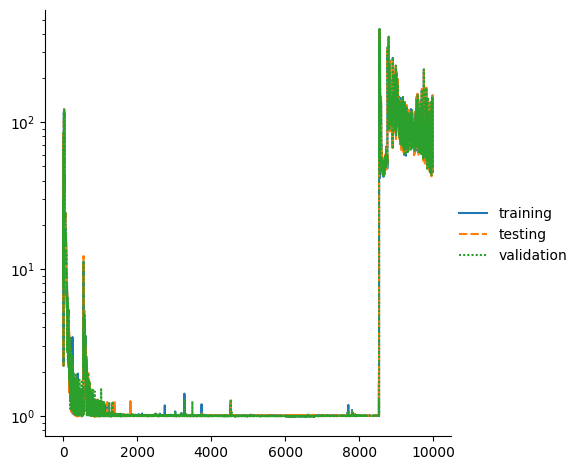

In [3]:
loss_g = sns.relplot(learning_curves.loc[:, (slice(None), 'loss')], kind='line', estimator=None)
loss_g.set(yscale = 'log')
#loss_g.set(xlim = (0, 10000))

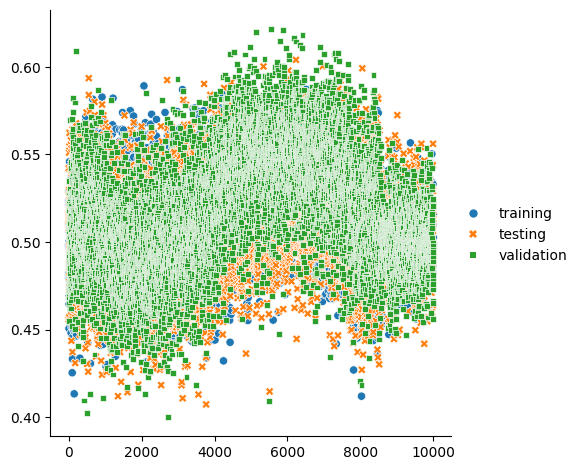

In [4]:
sns.relplot(learning_curves.loc[:, (slice(None), 'auroc')])

In [5]:
import sys
sys.path.append('..')

from train_nnc import NNConvNet
import torch

saved = torch.load('model.pt')
saved.keys()

dict_keys(['hyperparameters', 'parameters', 'best_epoch'])

In [6]:
saved['best_epoch']

5549

In [7]:
learning_curves.loc[saved['best_epoch']]

training    loss     0.999970
            auroc    0.539342
testing     loss     0.998368
            auroc    0.526346
validation  loss     0.993960
            auroc    0.621637
Name: 5549, dtype: float64

In [8]:
learning_curves.loc[:, (slice(None), 'auroc')].max(axis='index')

training    auroc    0.590312
testing     auroc    0.604029
validation  auroc    0.621637
dtype: float64

In [9]:
learning_curves.loc[:, (slice(None), 'loss')].min(axis='index')

training    loss    0.989666
testing     loss    0.983322
validation  loss    0.985643
dtype: float64

In [19]:
model = NNConvNet(**saved['hyperparameters'])
model.load_state_dict(saved['parameters'])
model.eval()

NNConvNet(
  (lin_in): Linear(in_features=18949, out_features=10, bias=True)
  (encoder): ModuleList(
    (0-1): 2 x Linear(in_features=10, out_features=10, bias=True)
  )
  (edge_nn): Sequential(
    (0): Linear(in_features=8, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (nnconv): ModuleList(
    (0-1): 2 x NNConv(10, 10, aggr=add, nn=Sequential(
      (0): Linear(in_features=8, out_features=100, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    ))
  )
  (decoder): ModuleList(
    (0-1): 2 x Linear(in_features=10, out_features=10, bias=True)
  )
  (lin_out): Linear(in_features=10, out_features=1, bias=True)
)

In [11]:
data = torch.load('../data/cpg0016_v1.pt')

In [20]:
with torch.no_grad():
    predict_df = pd.DataFrame({
        'y_hat': torch.softmax(model(data), dim=1)[:, 1],
        'y': data.y[:, 0]
    })
    predict_df['subset'] = 'Neither'
    predict_df['subset'][data.train_mask.numpy()] = 'Training'
    predict_df['subset'][data.test_mask.numpy()] = 'Testing'
    predict_df['subset'][data.val_mask.numpy()] = 'Validation'

/tmp/ipykernel_2538/2688595686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['subset'][data.train_mask.numpy()] = 'Training'
/tmp/ipykernel_2538/2688595686.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['subset'][data.test_mask.numpy()] = 'Testing'
/tmp/ipykernel_2538/2688595686.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['subset'][data.val_mask.numpy()] = 'Validation'


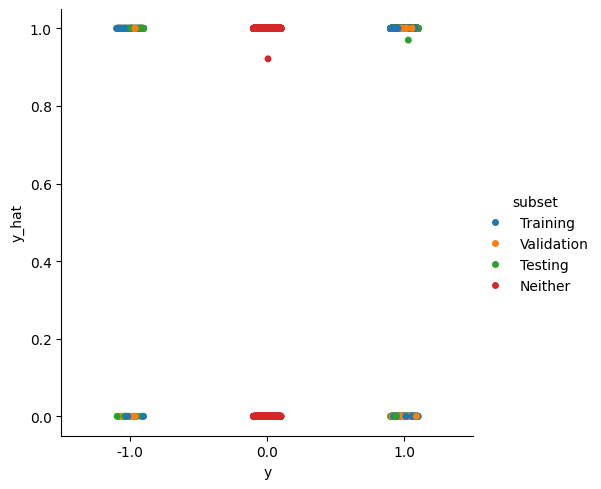

In [21]:
sns.catplot(predict_df, x='y', y='y_hat', hue='subset', kind='strip')

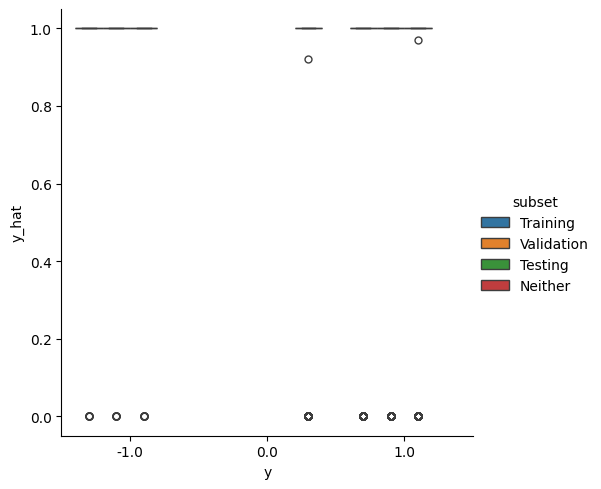

In [22]:
sns.catplot(predict_df, x='y', y='y_hat', hue='subset', kind='box')

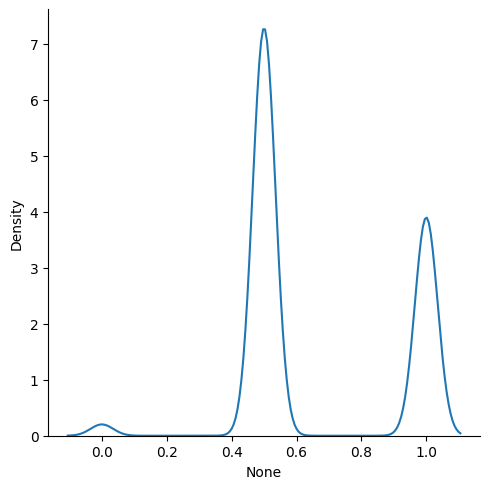

In [29]:
# Verify that data preprocessing isn't screwing this up
y_float = (data.y + 1) * 0.5
sns.displot(x=pd.Series(y_float[:,0].numpy()), kind='kde')

In [31]:
y_int = torch.tensor(y_float, dtype=torch.int64)
pd.Series(y_int[:,0].numpy()).value_counts()

/tmp/ipykernel_2538/4268706411.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_int = torch.tensor(y_float, dtype=torch.int64)


0    12746
1     6639
Name: count, dtype: int64

In [32]:
for mask in (data.train_mask, data.test_mask, data.val_mask):
    print(pd.Series(y_int[mask,0].numpy()).value_counts())

1    2656
0     137
Name: count, dtype: int64
1    1992
0     104
Name: count, dtype: int64
1    1993
0     103
Name: count, dtype: int64
